In [1]:
import phoebe
from phoebe import u, c

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 6)

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
import analisis.phoebe_model.optimizers.opt_utils as opt_utils
importlib.reload(gen_utils)
importlib.reload(opt_utils)

logger = phoebe.logger(clevel='WARNING')

In [2]:
# b = phoebe.load("../estimations/bundle-saves/aviles-iturbide-gaia-ztf-ltt/ebai-estimates-trimmed")
b = phoebe.load("../estimations/bundle-saves/aviles-iturbide-gaia-ztf-ltt-relative_norm/ebai-estimates-trimmed")

In [3]:
print(b['enabled'])

ParameterSet: 13 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@lc_iturbide_norm@ph...: True
   enabled@lc_iturbide_raw@pho...: True
   enabled@lc_iturbide_aviles_...: True
   enabled@lc_iturbide_aviles_...: True
   enabled@lc_gaia_g_norm@phoe...: True
   enabled@lc_gaia_rp_norm@pho...: True
   enabled@lc_gaia_bp_norm@pho...: True
   enabled@lc_gaia_g_raw@phoeb...: True
   enabled@lc_gaia_rp_raw@phoe...: True
   enabled@lc_gaia_bp_raw@phoe...: True
   enabled@lcZtfG@phoebe01@com...: True
   enabled@lcZtfR@phoebe01@com...: True


In [4]:
rawGaiaDatasets = [d for d in b.datasets if 'raw' in d and 'gaia' in d]
normGaiaDatasets = [d for d in b.datasets if 'norm' in d and 'gaia' in d]
ztfDatasets = [d for d in b.datasets if 'Ztf' in d]

rawDatasetPlotGroups = [['lc_iturbide_raw'], ['lc_iturbide_aviles_raw'], rawGaiaDatasets]
normDatasetPlotGroups = [['lc_iturbide_norm'], ['lc_iturbide_aviles_norm'], normGaiaDatasets, ztfDatasets]
allDatasetPlotGroups = rawDatasetPlotGroups + normDatasetPlotGroups

100%|██████████| 3673/3673 [10:43<00:00,  5.71it/s]
Tue, 12 Dec 2023 12:33 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'
Tue, 12 Dec 2023 12:33 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


before_optimizers
	 Iturbide (Aviles) (Raw) - 18109217111.55099
	 Iturbide (Full) (Raw) - 265597.22928488976
	 Gaia (Raw) - 19757.86303394763
		 lc_gaia_g_raw - 13229.17669350356
		 lc_gaia_rp_raw - 4308.280464088302
		 lc_gaia_bp_raw - 2220.4058763557696
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.687318913960486
	 Iturbide (Full) (Norm) - 43816.40841331415
	 Gaia (Norm) - 19757.86303394768
		 lc_gaia_g_norm - 13229.17669350362
		 lc_gaia_rp_norm - 4308.2804640883005
		 lc_gaia_bp_norm - 2220.405876355764
	 ZTF - 32179.10203628677
		 lcZtfG - 7510.758185009429
		 lcZtfR - 24668.343851277343


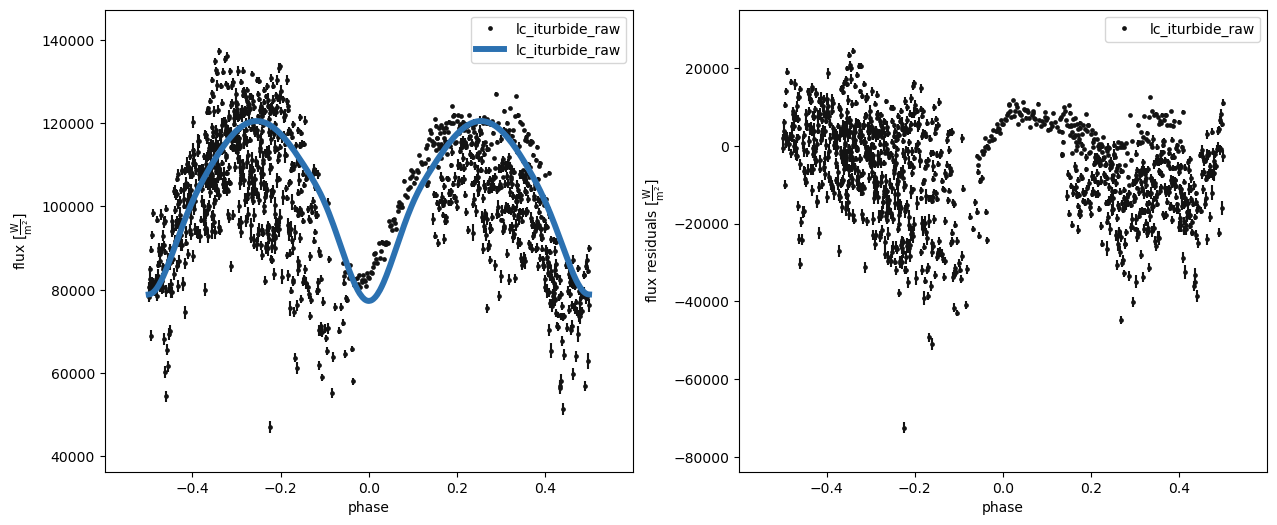

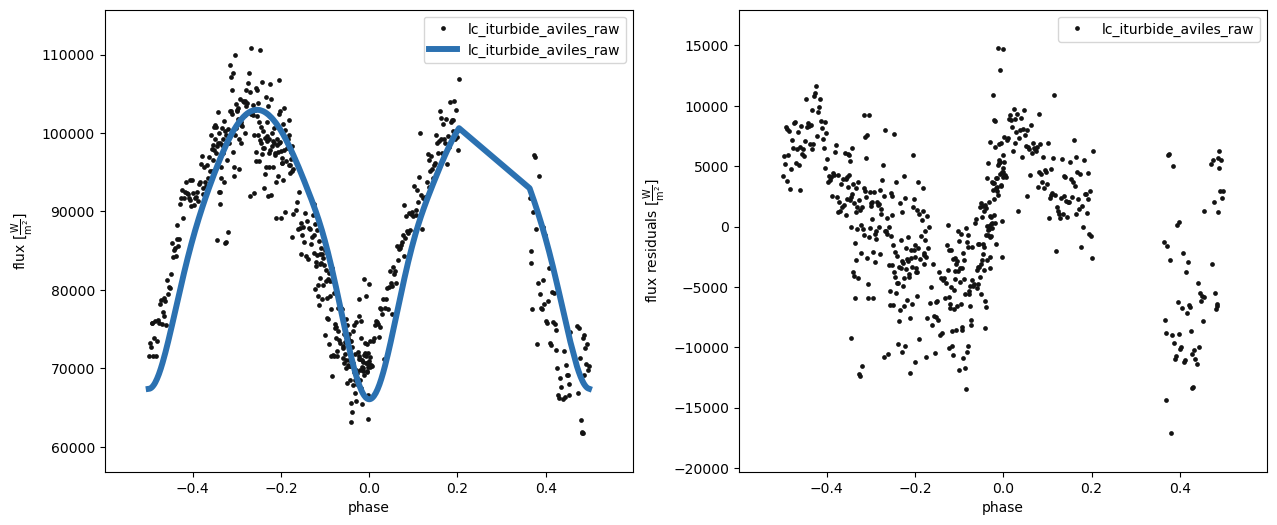

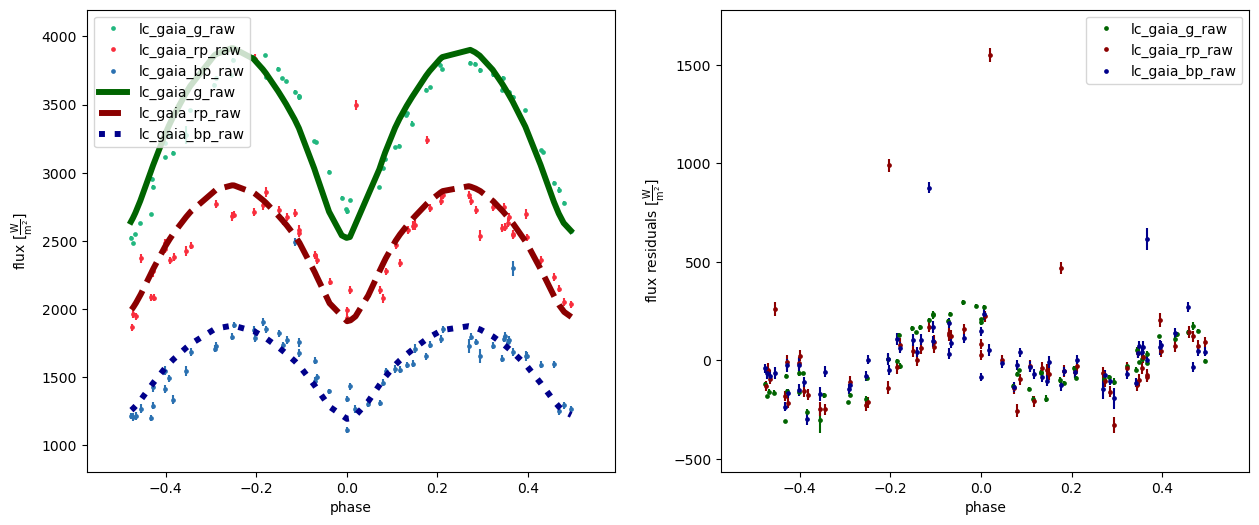

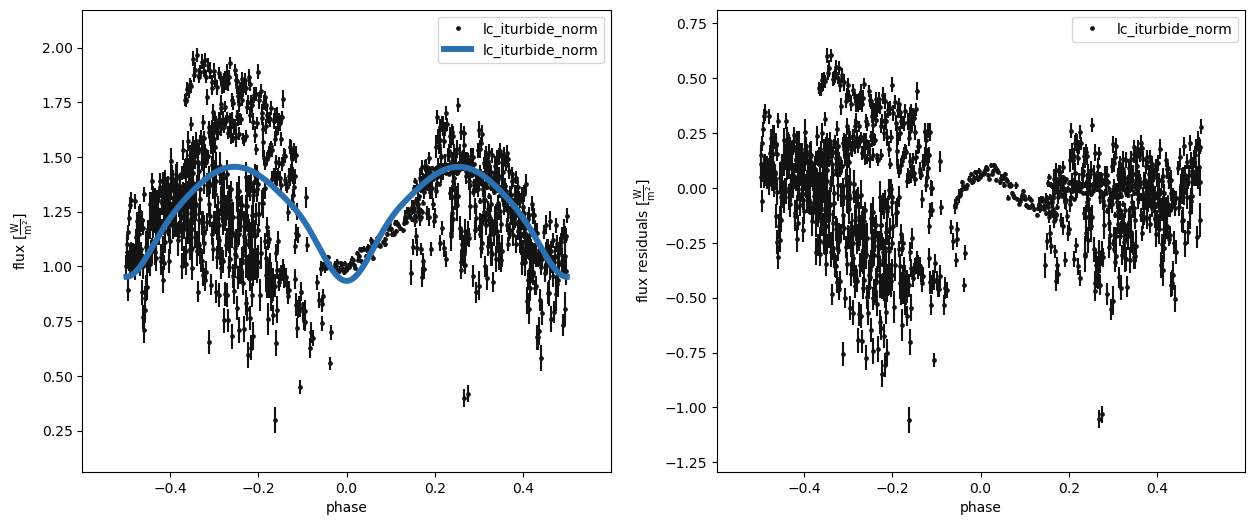

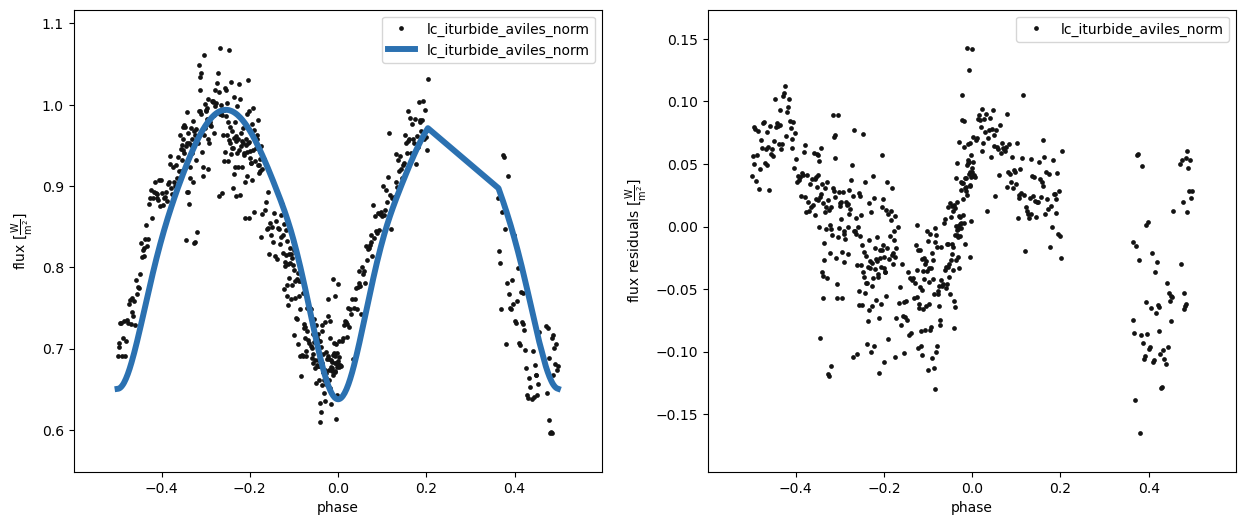

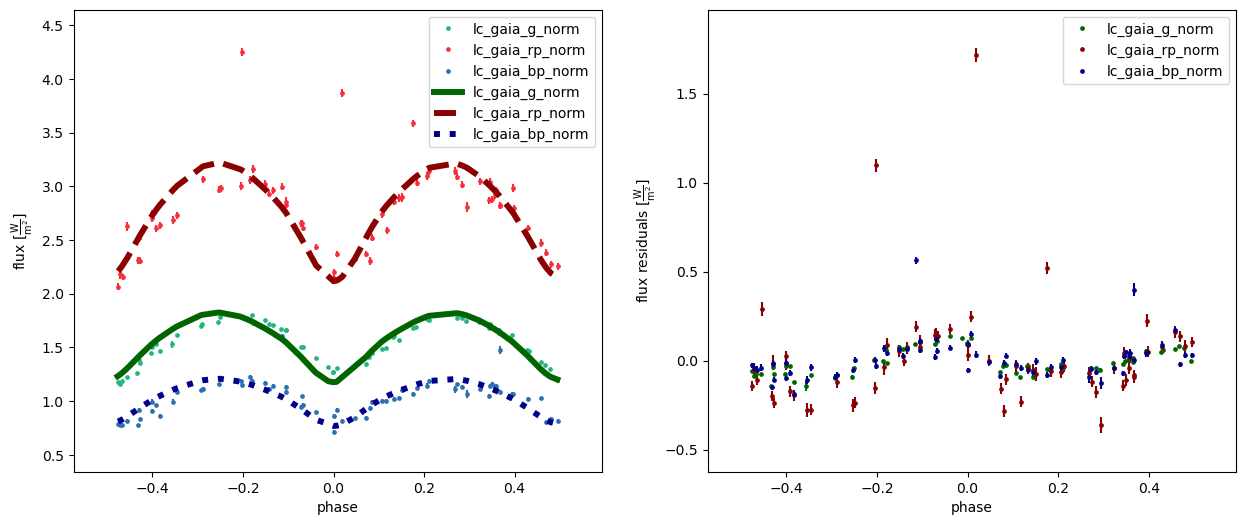

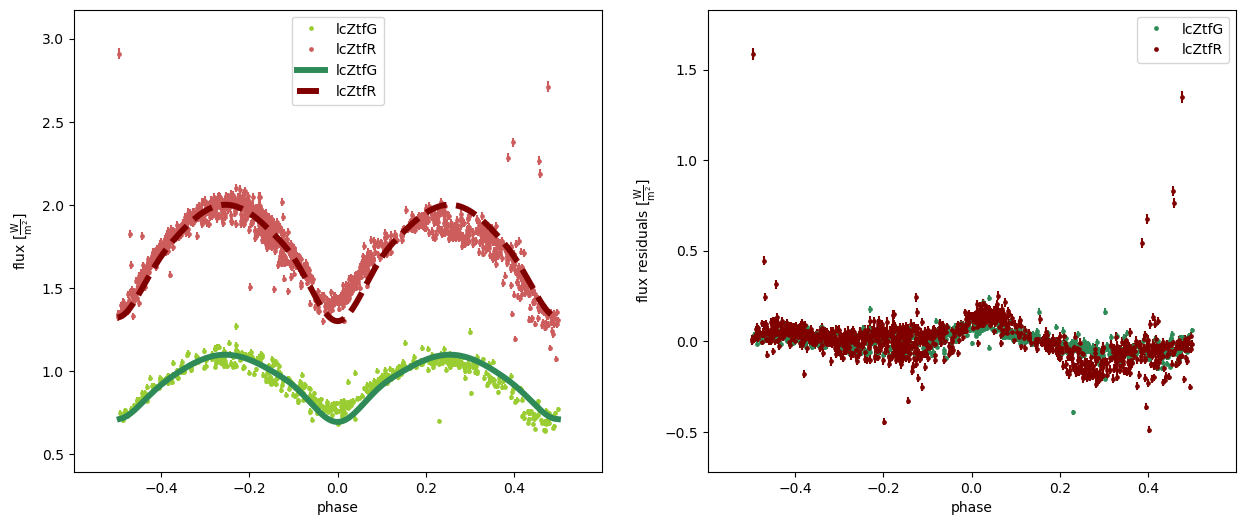

In [5]:
b.run_compute(model='before_optimizers', overwrite=True)
gen_utils.printChi2(b, 'before_optimizers')
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(15, 6), datasetGroups=allDatasetPlotGroups, model='before_optimizers')

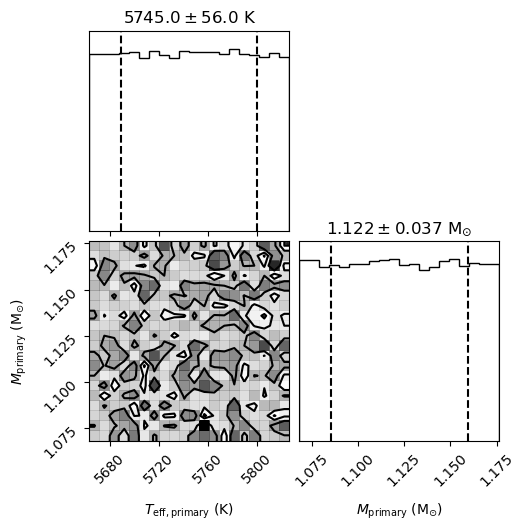

In [6]:
_ = b.plot_distribution_collection('poro_porb_bounds')

# Initial Parameters

In [7]:
print(b['q'])
print(b['mass'])
print(b['requiv'])
print(b['teff'])
print(b['teffratio'])
print(b['fillout_factor'])
print(b['incl@binary'])

Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 1.8564781150410867
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, sma@binary@component, sma@primary@component, asini@primary@component, requiv_max@primary@component, requiv_min@primary@component, mass@secondary@component, sma@secondary@component, asini@secondary@component, requiv_max@secondary@component, requiv_min@secondary@component
                      Related to: pot@contact_envelope@component, sma@binary@component, requiv@primary@component, requiv@secondary@component, fillout_factor@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, mass@primary@component, period@binary@component, sma@primary@component, incl@bina

In [8]:
print(b['t0_supconj'])

Parameter: t0_supconj@binary@component
                       Qualifier: t0_supconj
                     Description: Zeropoint date at superior conjunction of the primary component
                           Value: -0.03747659625944774 d
                  Constrained by: 
                      Constrains: t0_perpass@binary@component, t0_ref@binary@component, compute_phases@mesh01@dataset, compute_phases@lc_iturbide_norm@dataset, compute_phases@lc_iturbide_raw@dataset, compute_phases@lc_iturbide_aviles_norm@dataset, compute_phases@lc_iturbide_aviles_raw@dataset, compute_phases@lc_gaia_g_norm@dataset, compute_phases@lc_gaia_rp_norm@dataset, compute_phases@lc_gaia_bp_norm@dataset, compute_phases@lc_gaia_g_raw@dataset, compute_phases@lc_gaia_rp_raw@dataset, compute_phases@lc_gaia_bp_raw@dataset, compute_phases@lcZtfG@dataset, compute_phases@lcZtfR@dataset
                      Related to: period@binary@component, ecc@binary@component, per0@binary@component, dpdt@binary@component, dperdt@b

# Period and `t0_supconj`

Eclipse timings look off from model to light curves, from slight positional offset.

In [9]:
opt_utils.optimize_params(b, fit_twigs=['period@binary', 't0_supconj'], label='per_t0', export=True, subfolder="iturbide-gaia-ztf-relative_norm", 
						  datasets=['lc_iturbide_norm', 'lc_iturbide_aviles_norm'] + normGaiaDatasets + ztfDatasets, maxiter=200)

External Solver: ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_per_t0.py ./results/opt_per_t0_solution


('opt_per_t0', 'opt_per_t0_solution')

Tue, 12 Dec 2023 12:34 BUNDLE       WARNING not all uniqueids in fitted_uniqueids@opt_per_t0_solution@solution are still valid.  Falling back on twigs.  Save and load same bundle to prevent this extra cost.


Adopted:
period@binary@orbit@component = 0.33357 d
t0_supconj@binary@orbit@component = -0.03754 d

Original values:
  period@binary@orbit@component 0.333566999 d
  t0_supconj@binary@orbit@component -0.03747659625944774 d


100%|██████████| 3673/3673 [10:47<00:00,  5.67it/s]
Tue, 12 Dec 2023 12:45 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'
Tue, 12 Dec 2023 12:45 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


before_optimizers
	 Iturbide (Aviles) (Raw) - 18109217111.55099
	 Iturbide (Full) (Raw) - 265597.22928488976
	 Gaia (Raw) - 19757.86303394763
		 lc_gaia_g_raw - 13229.17669350356
		 lc_gaia_rp_raw - 4308.280464088302
		 lc_gaia_bp_raw - 2220.4058763557696
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.687318913960486
	 Iturbide (Full) (Norm) - 43816.40841331415
	 Gaia (Norm) - 19757.86303394768
		 lc_gaia_g_norm - 13229.17669350362
		 lc_gaia_rp_norm - 4308.2804640883005
		 lc_gaia_bp_norm - 2220.405876355764
	 ZTF - 32179.10203628677
		 lcZtfG - 7510.758185009429
		 lcZtfR - 24668.343851277343
opt_per_t0_model
	 Iturbide (Aviles) (Raw) - 11589742432.3405
	 Iturbide (Full) (Raw) - 211488.2178310823
	 Gaia (Raw) - 10448.924385175389
		 lc_gaia_g_raw - 4912.824726698158
		 lc_gaia_rp_raw - 3853.7444540805977
		 lc_gaia_bp_raw - 1682.3552043966338
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.0798695213359042
	 Iturbide (F

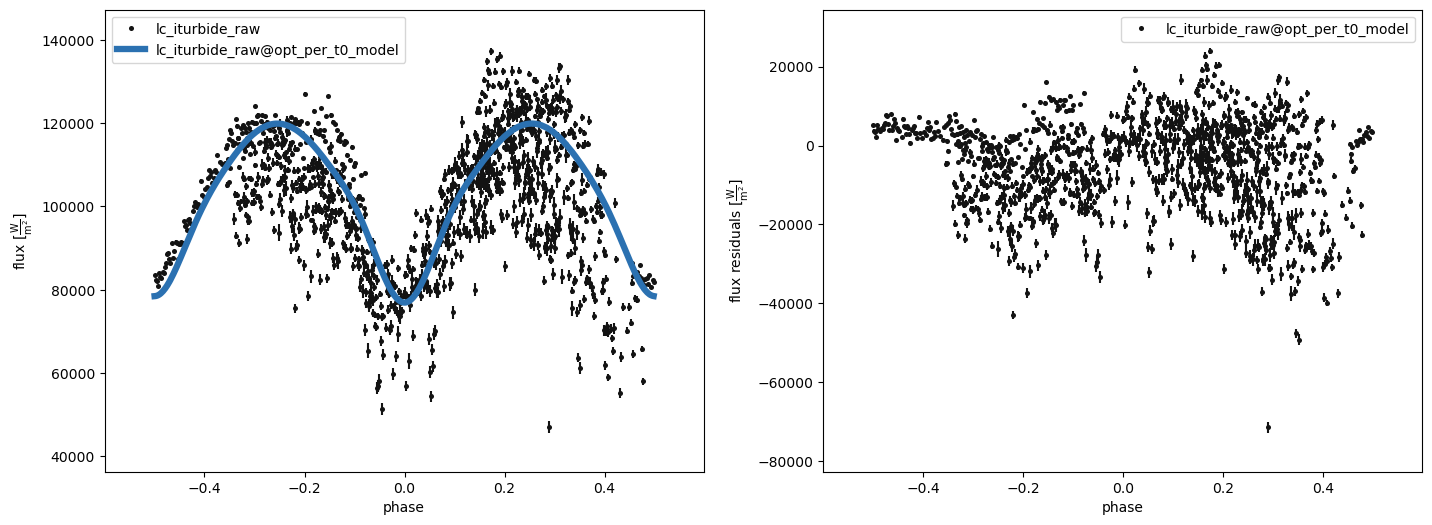

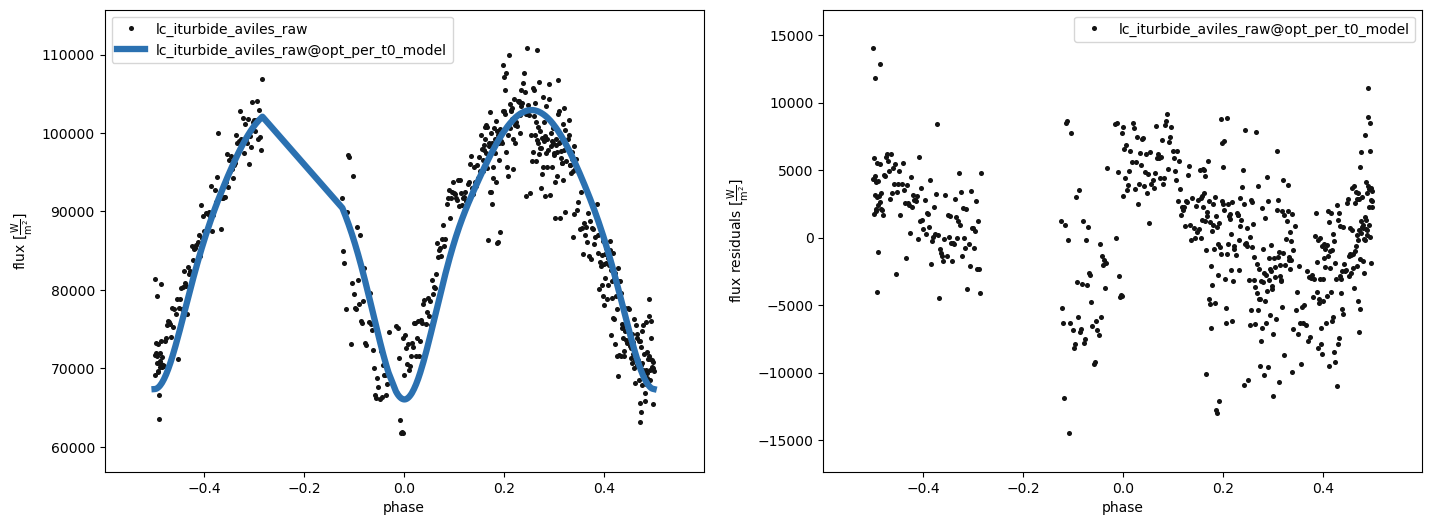

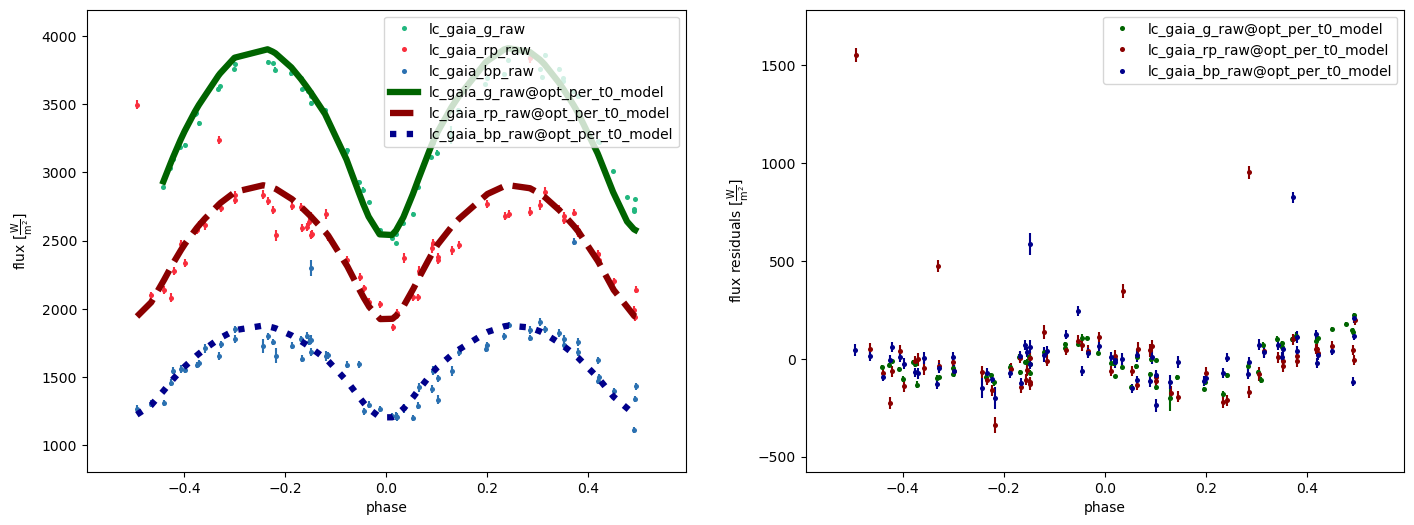

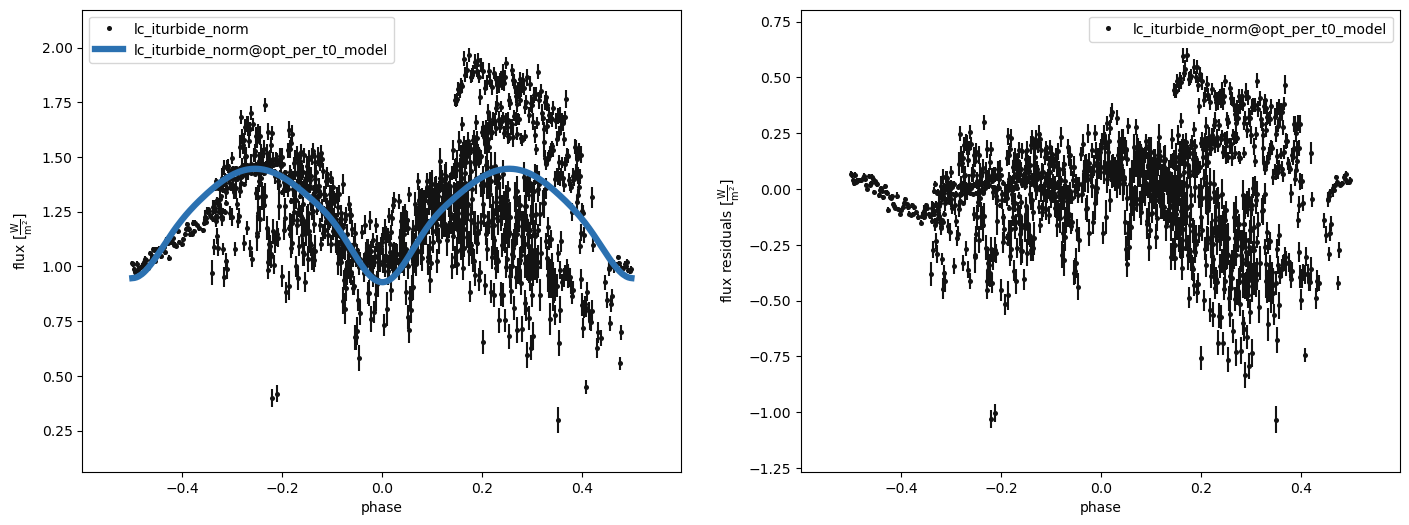

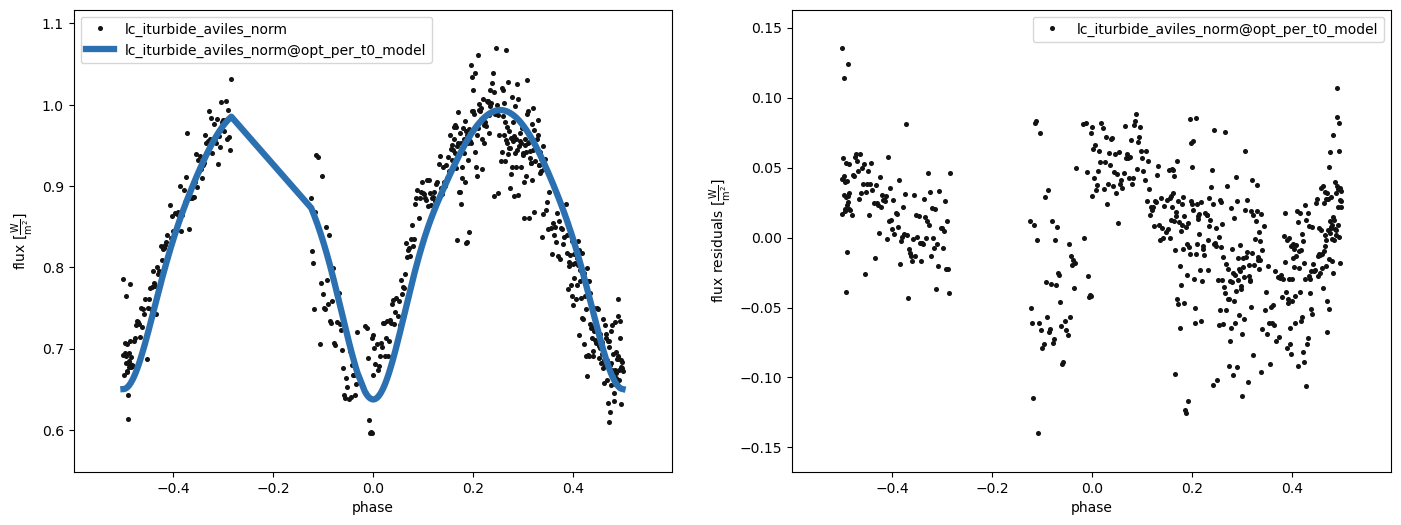

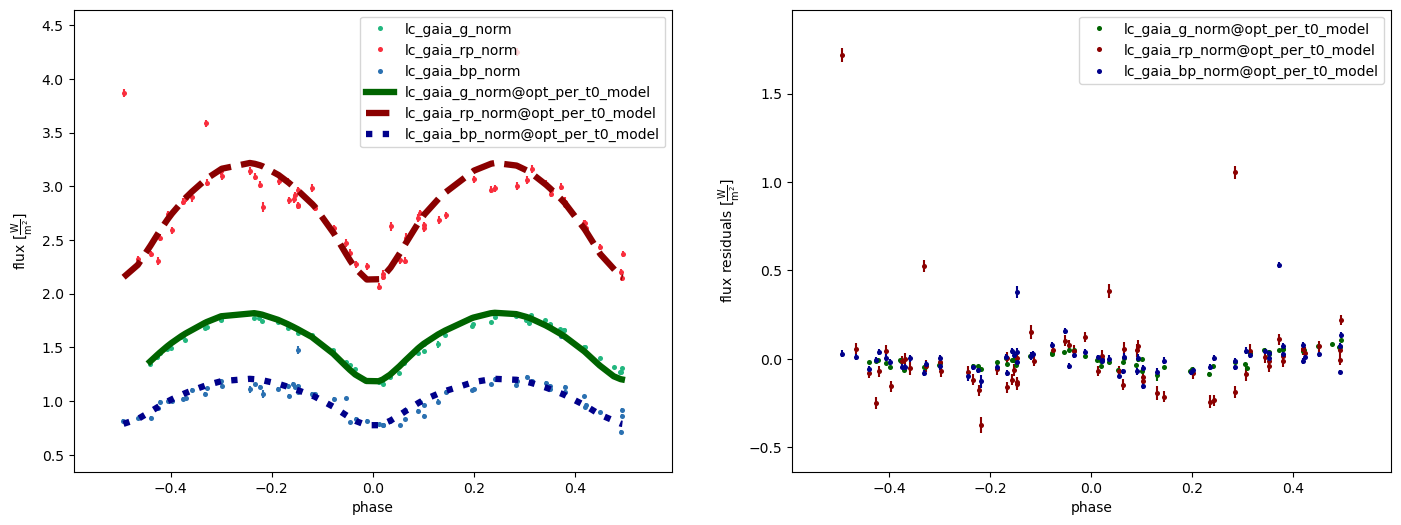

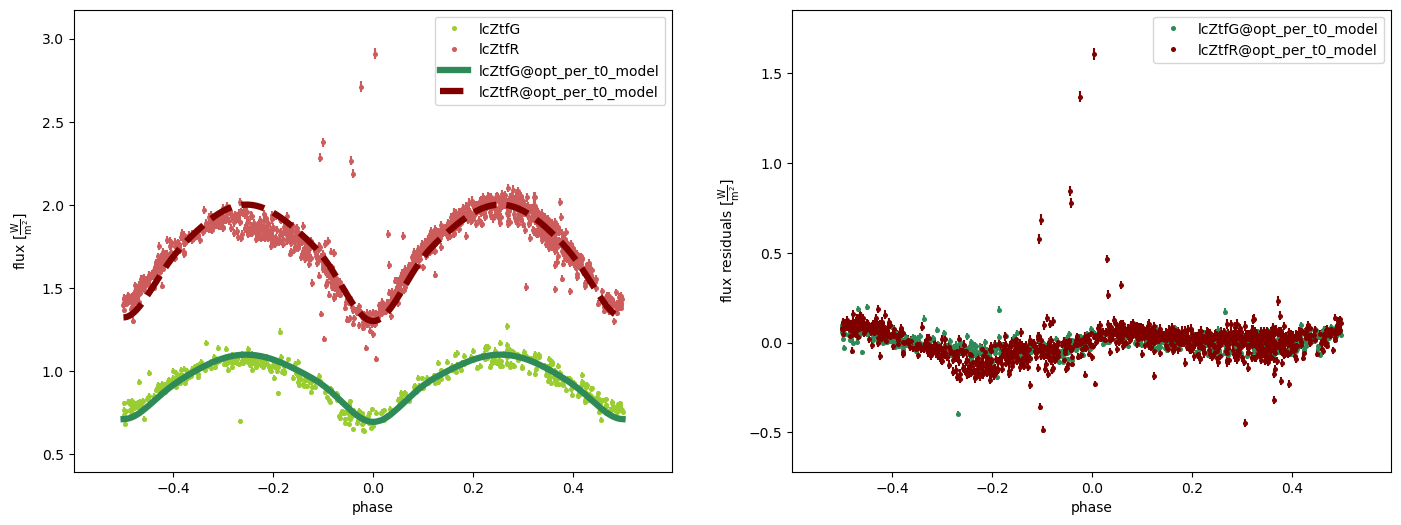

In [10]:
# using previous normalization solution; *should* be an applicable solution
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/iturbide-gaia-ztf-ltt/results/opt_per_t0_solution", reset_params=False)
gen_utils.printAllModelsChi2(b)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(17, 6), datasetGroups=allDatasetPlotGroups, model=computeModelName)

# Eclipse Width and Depth

Adjusting $T_{eff}$ ratio (`teffratio`) based on eclipse depths, alongside the fillout factor (`fillout_factor`) to adjust the eclipse widths. Fillout factor
parametrization of component radii.

In [11]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], "teffr_ff_vis", export=True, subfolder="iturbide-gaia-ztf-relative_norm", 
						  datasets=['lc_iturbide_norm', 'lc_iturbide_aviles_norm'] + normGaiaDatasets + ztfDatasets, maxiter=200)

External Solver: ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_teffr_ff_vis.py ./results/opt_teffr_ff_vis_solution


('opt_teffr_ff_vis', 'opt_teffr_ff_vis_solution')

Adopted:
teffratio@binary@orbit@component = 0.96753 
fillout_factor@contact_envelope@envelope@component = 0.03527 

Original values:
  teffratio@binary@orbit@component 0.9857284692267768
  fillout_factor@contact_envelope@envelope@component 0.1852193760747716


100%|██████████| 3657/3657 [10:57<00:00,  5.56it/s]
Tue, 12 Dec 2023 12:56 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'


before_optimizers
	 Iturbide (Aviles) (Raw) - 18109217111.55099
	 Iturbide (Full) (Raw) - 265597.22928488976
	 Gaia (Raw) - 19757.86303394763
		 lc_gaia_g_raw - 13229.17669350356
		 lc_gaia_rp_raw - 4308.280464088302
		 lc_gaia_bp_raw - 2220.4058763557696
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.687318913960486
	 Iturbide (Full) (Norm) - 43816.40841331415
	 Gaia (Norm) - 19757.86303394768
		 lc_gaia_g_norm - 13229.17669350362
		 lc_gaia_rp_norm - 4308.2804640883005
		 lc_gaia_bp_norm - 2220.405876355764
	 ZTF - 32179.10203628677
		 lcZtfG - 7510.758185009429
		 lcZtfR - 24668.343851277343
opt_per_t0_model
	 Iturbide (Aviles) (Raw) - 11589742432.3405
	 Iturbide (Full) (Raw) - 211488.2178310823
	 Gaia (Raw) - 10448.924385175389
		 lc_gaia_g_raw - 4912.824726698158
		 lc_gaia_rp_raw - 3853.7444540805977
		 lc_gaia_bp_raw - 1682.3552043966338
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.0798695213359042
	 Iturbide (F

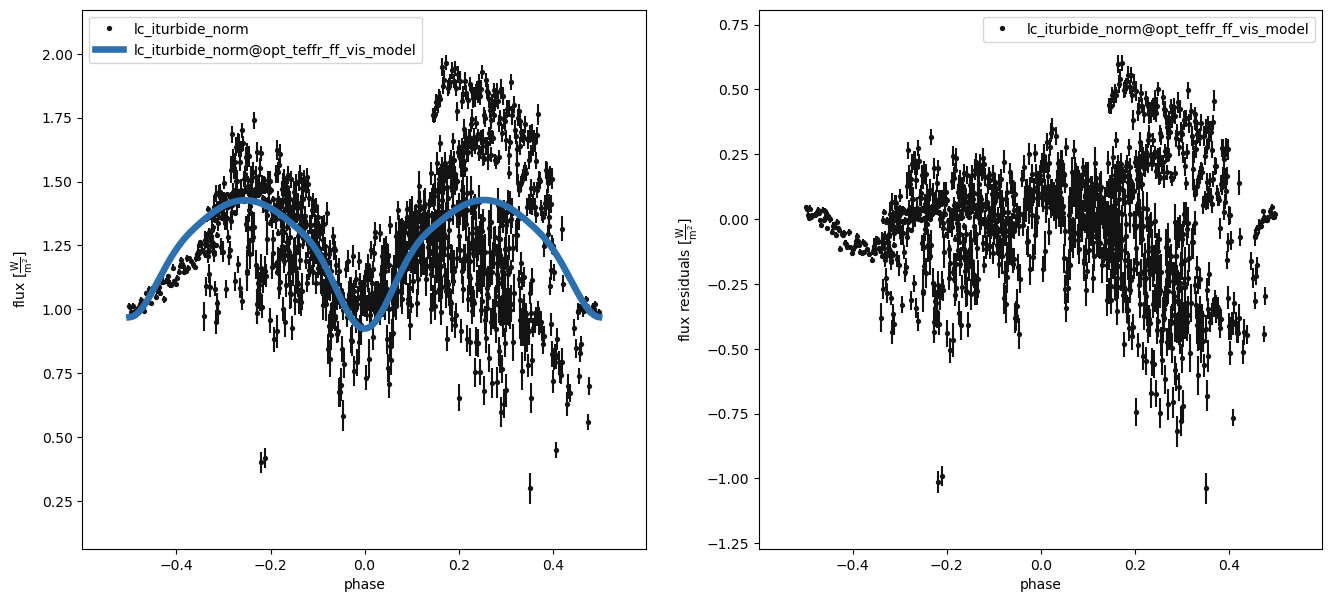

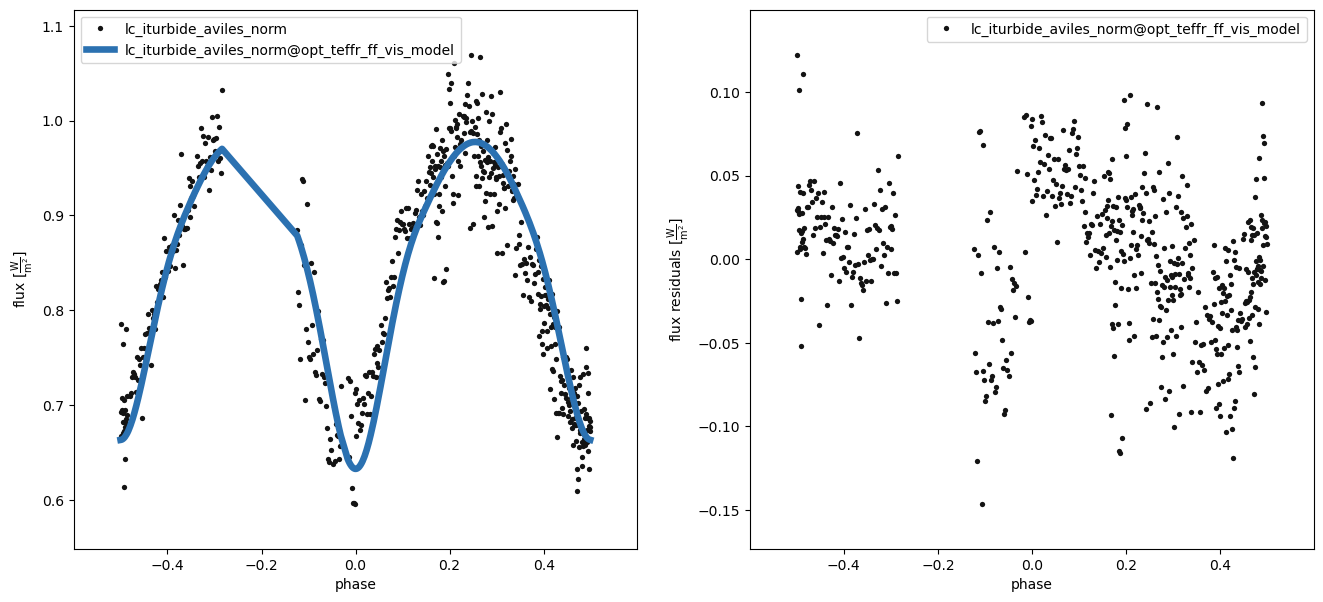

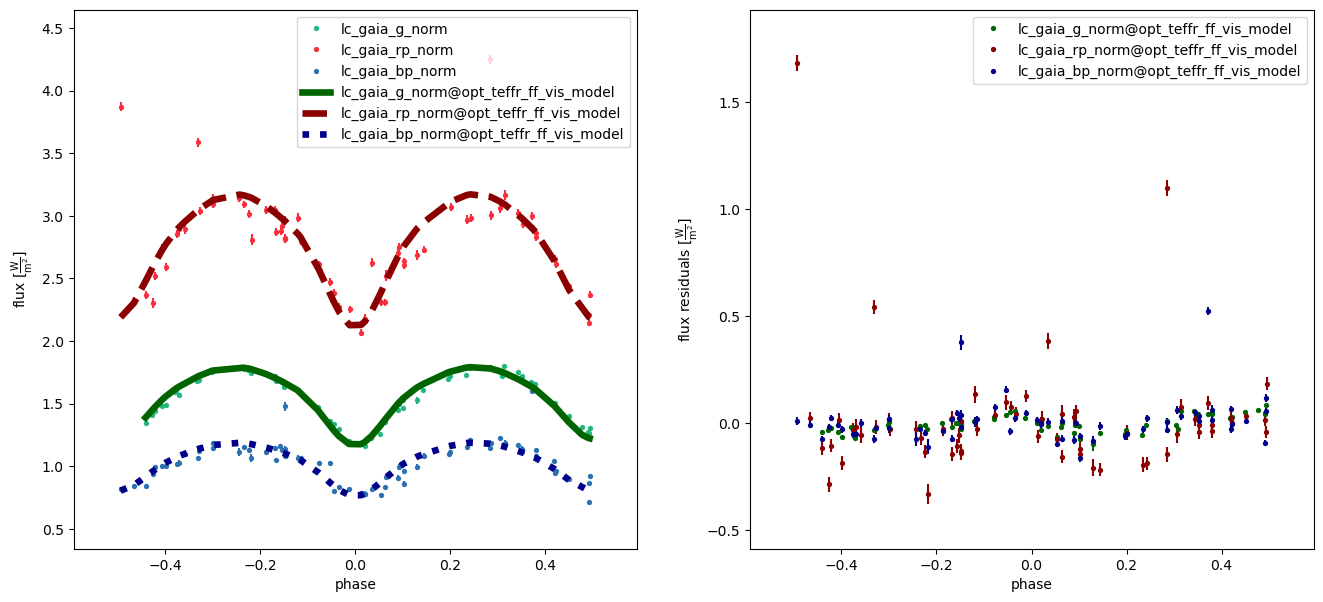

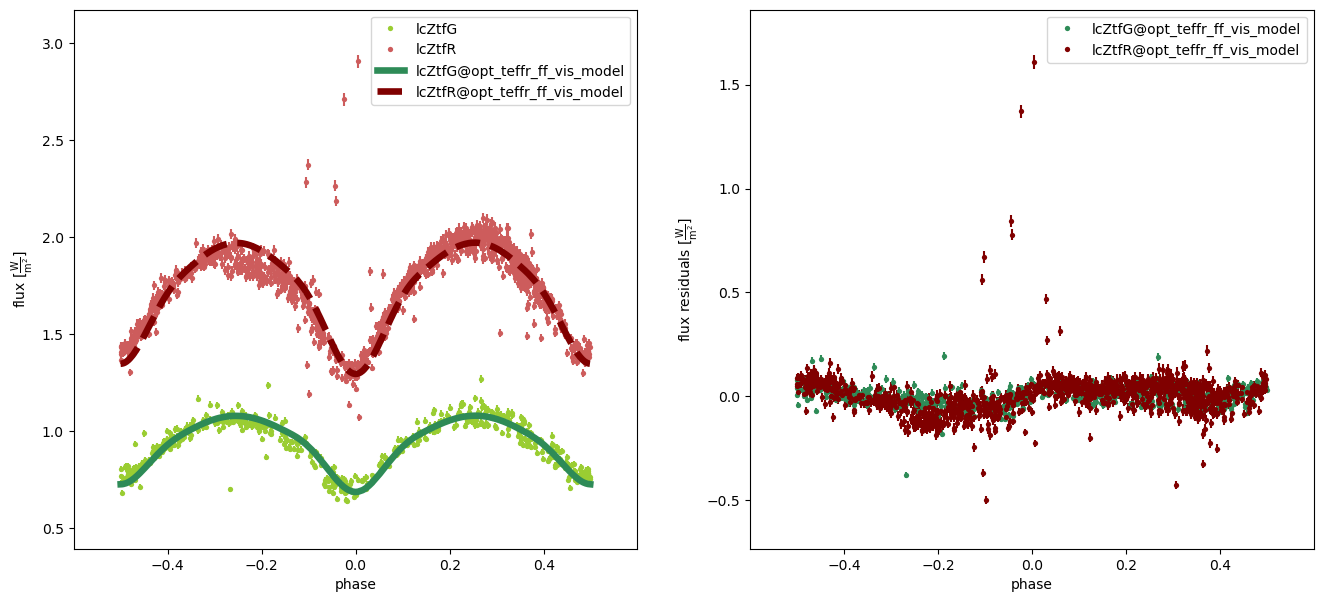

In [12]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_teffr_ff_vis_solution", 
														  reset_params=True, dataset=['lc_iturbide_norm', 'lc_iturbide_aviles_norm'] + normGaiaDatasets + ztfDatasets)
gen_utils.printAllModelsChi2(b)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(16, 7), datasetGroups=normDatasetPlotGroups, model=computeModelName)

## Adjusting Component $T_{eff}$

Since these parameters are some of the last that will likely need to be adjusted for this model, here we try adjusting the component $T_{eff}$ using the color
difference from each set of light curves. The optimized temperatures will need to agree with Gaia and ZTF data, since this is where we have color information.

Will run 3 separate optimizers; one including normalized datasets only (+ZTF), one including raw datasets only (-ZTF), and one with raw datasets + ZTF normalized.

In [13]:
pb_backup = b.copy()

In [20]:
%%script echo "skip unless need to restore from backup"
b = pb_backup.copy()

In [21]:
b.set_value_all(qualifier='pblum_mode', 
				dataset=['lc_iturbide_raw', 'lc_iturbide_norm', 'lc_iturbide_aviles_raw', 'lc_iturbide_aviles_norm', 
			 			'lc_gaia_rp_raw', 'lc_gaia_rp_norm', 'lc_gaia_g_raw', 'lc_gaia_g_norm', 
						'lcZtfG'], 
				value='component-coupled')

# coupling Gaia BP and RP; Gaia G will be treated separately
b.set_value(qualifier='pblum_mode', dataset='lc_gaia_bp_raw', value='dataset-coupled')
b.set_value(qualifier='pblum_dataset', dataset='lc_gaia_bp_raw', value='lc_gaia_rp_raw')

b.set_value(qualifier='pblum_mode', dataset='lc_gaia_bp_norm', value='dataset-coupled')
b.set_value(qualifier='pblum_dataset', dataset='lc_gaia_bp_norm', value='lc_gaia_rp_norm')

# coupling ZTF color to ZTF_G
b.set_value(qualifier='pblum_mode', dataset='lcZtfR', value='dataset-coupled')
b.set_value(qualifier='pblum_dataset', dataset='lcZtfR', value='lcZtfG')

In [15]:
# UNUSED FOR NOW; testing coupling different Gaia curves together instead above
%%script echo "skipping in favor of color coupling above"

b.set_value_all(qualifier='pblum_mode', 
				dataset=['lc_iturbide_raw', 'lc_iturbide_norm', 'lc_iturbide_aviles_raw', 'lc_iturbide_aviles_norm', 'lc_gaia_g_raw', 'lc_gaia_g_norm', 'lcZtfG'], 
				value='component-coupled')

# coupling Gaia color LCs to Gaia_G
b.set_value_all(qualifier='pblum_mode', dataset=['lc_gaia_rp_raw', 'lc_gaia_bp_raw'], value='dataset-coupled')
b.set_value_all(qualifier='pblum_dataset', dataset=['lc_gaia_rp_raw', 'lc_gaia_bp_raw'], value='lc_gaia_g_raw')

b.set_value_all(qualifier='pblum_mode', dataset=['lc_gaia_rp_norm', 'lc_gaia_bp_norm'], value='dataset-coupled')
b.set_value_all(qualifier='pblum_dataset', dataset=['lc_gaia_rp_norm', 'lc_gaia_bp_norm'], value='lc_gaia_g_norm')

# coupling ZTF color to ZTF_G
b.set_value(qualifier='pblum_mode', dataset='lcZtfR', value='dataset-coupled')
b.set_value(qualifier='pblum_dataset', dataset='lcZtfR', value='lcZtfG')

100%|██████████| 3673/3673 [11:21<00:00,  5.39it/s]


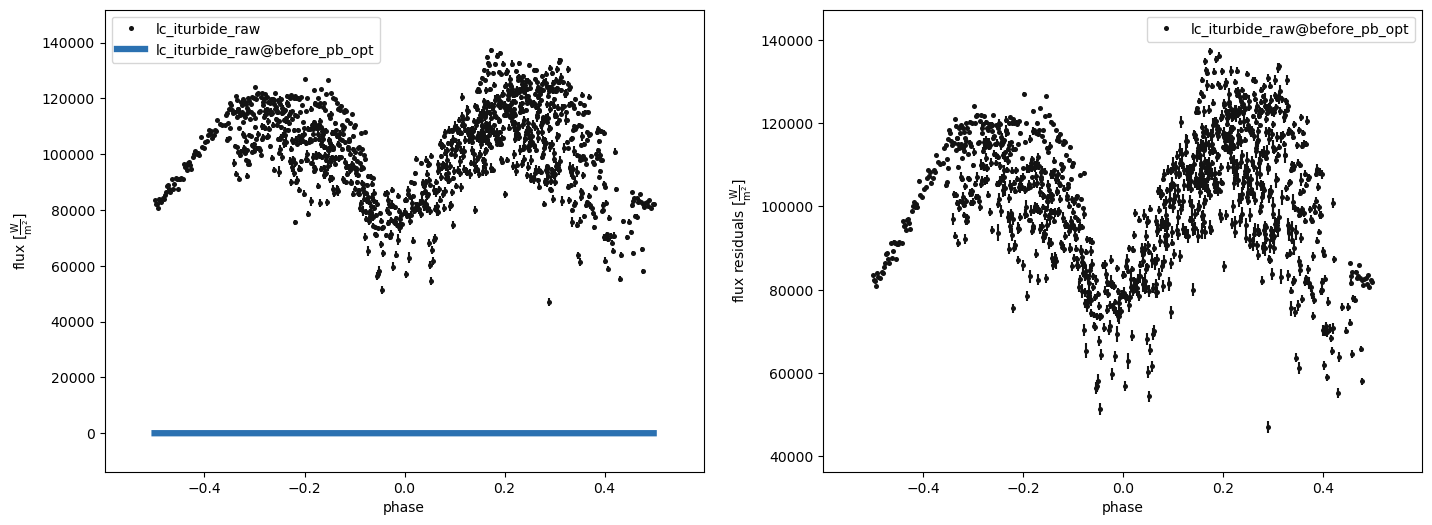

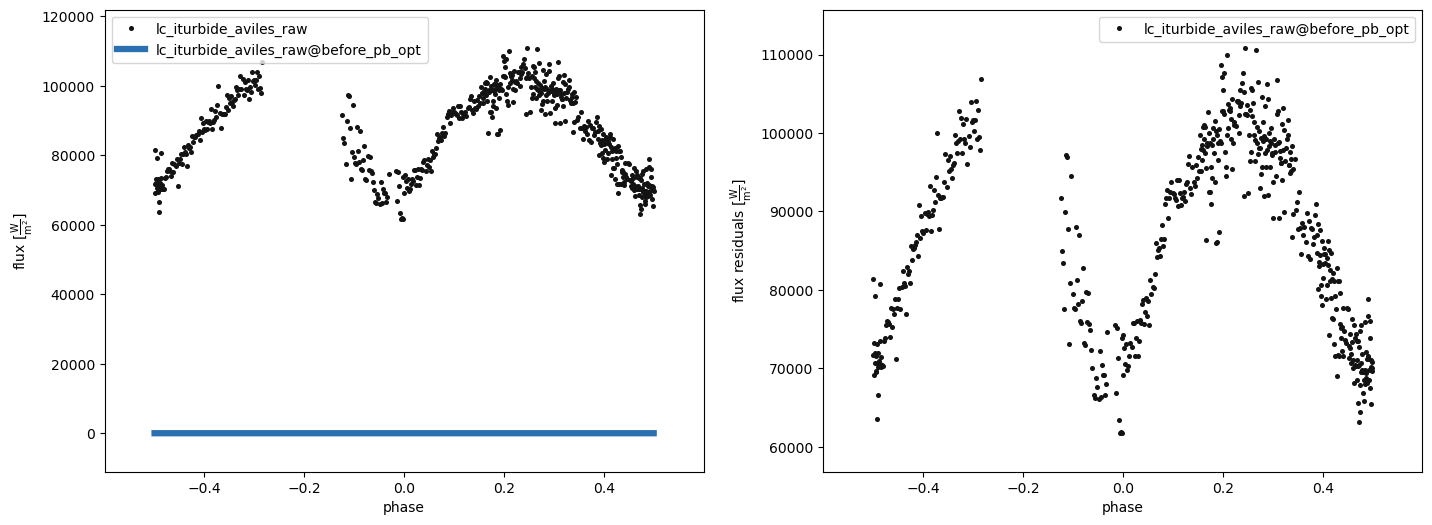

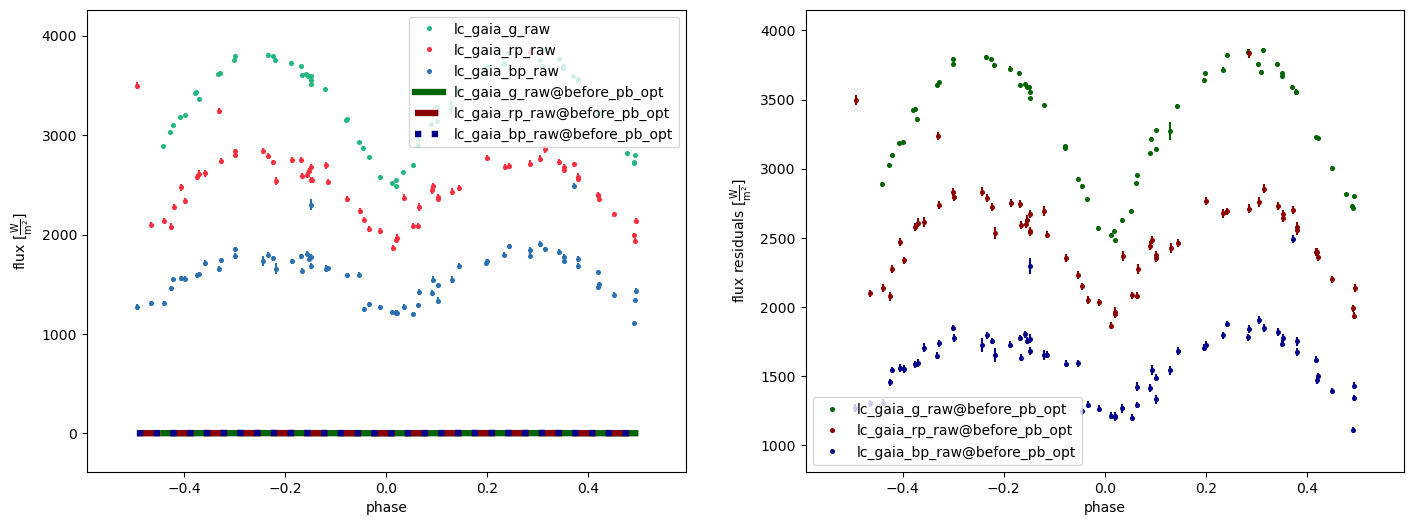

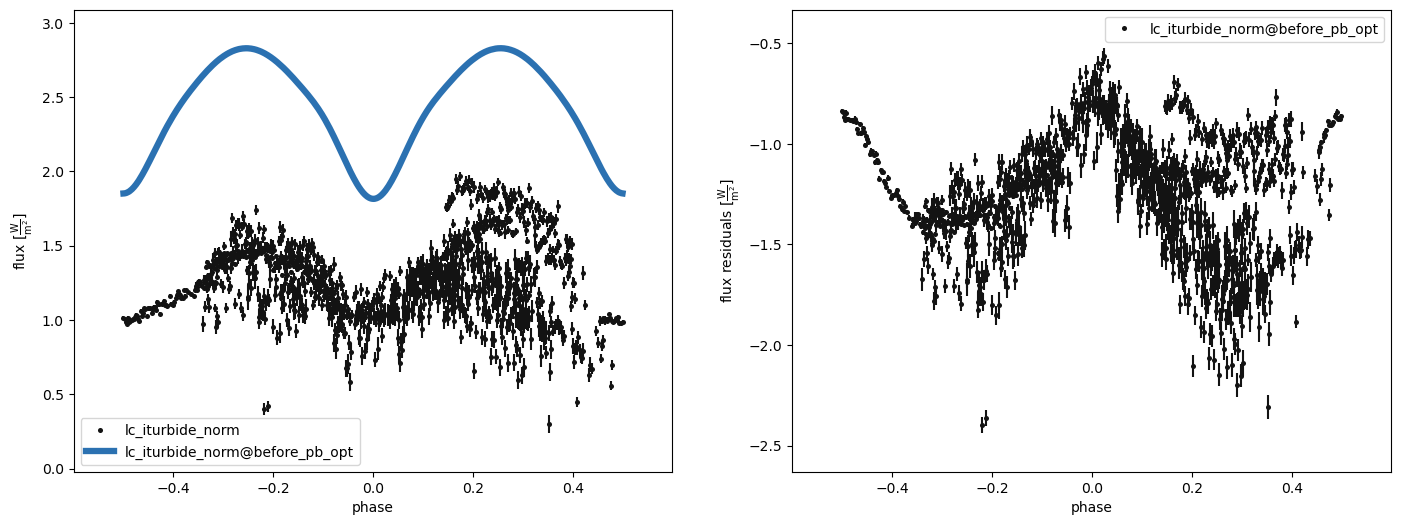

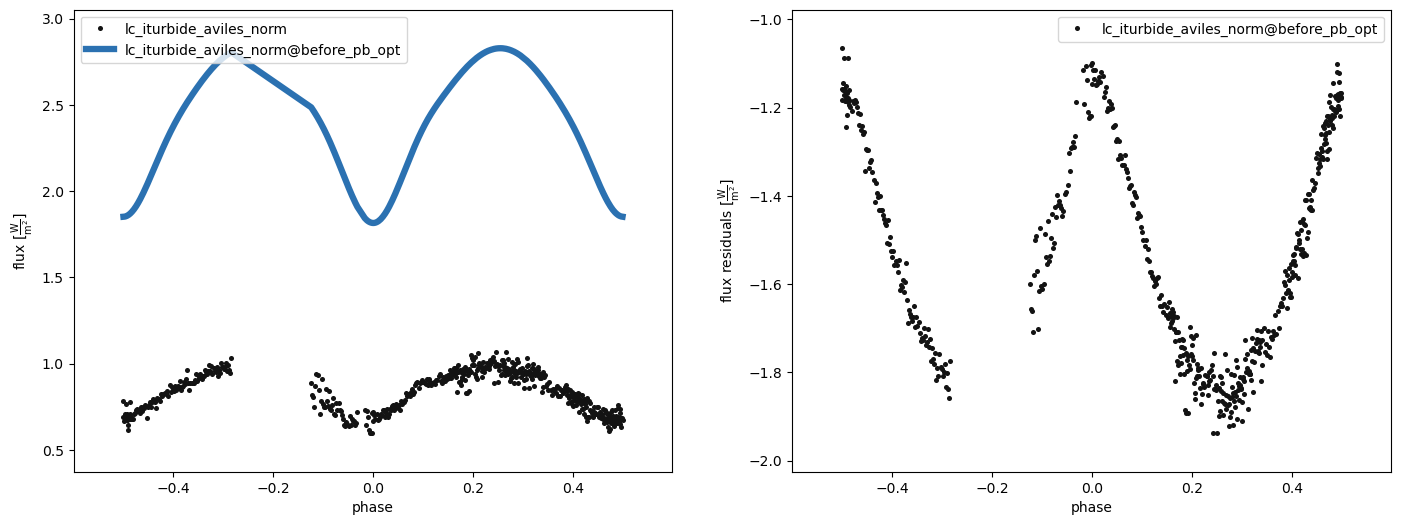

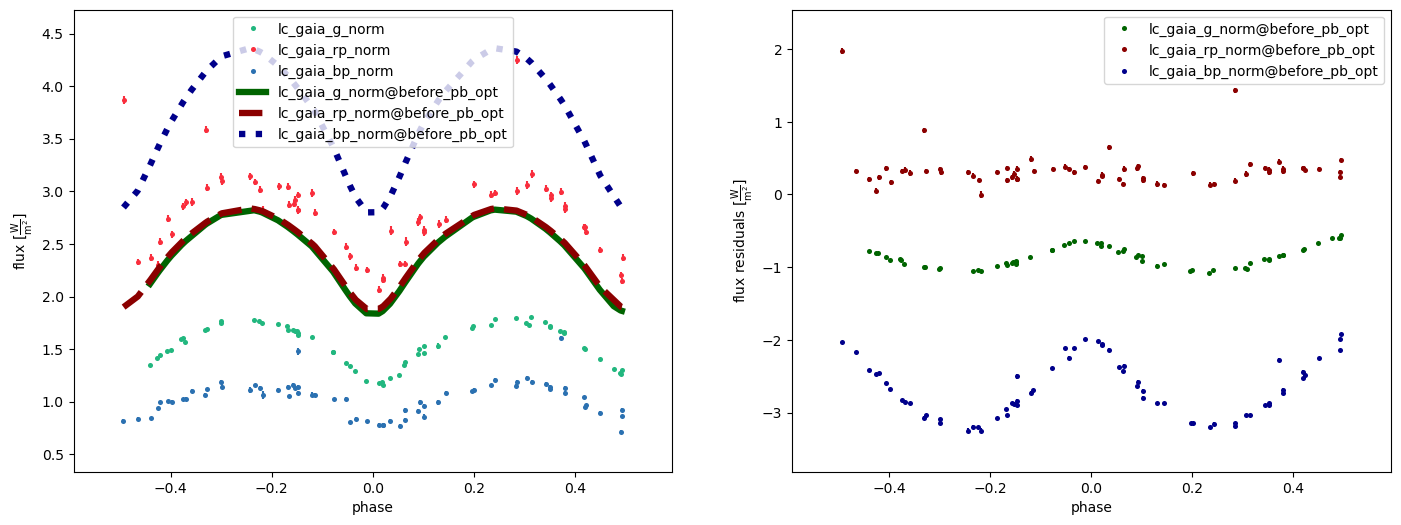

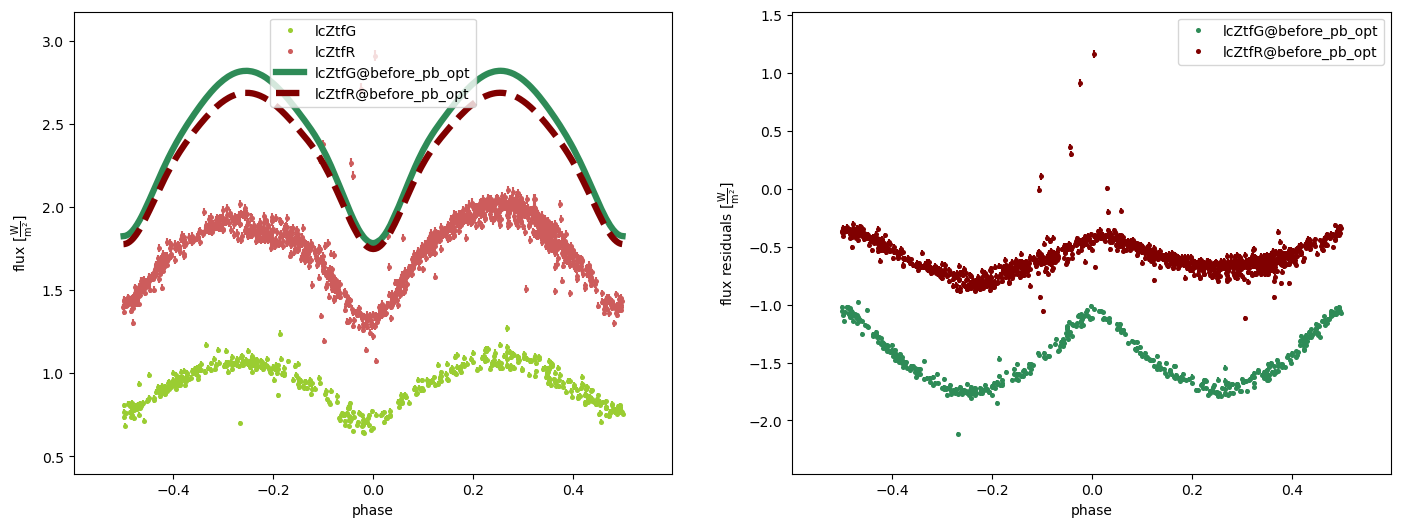

In [22]:
b.set_value_all(qualifier='enabled', value=True)
b.run_compute(model='before_pb_opt', overwrite=True)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(17, 6), datasetGroups=allDatasetPlotGroups, model='before_pb_opt')

### Original Adjustment

Coupled all Gaia LCs together; **results in bad temperature adjustment**

In [17]:
# normalized datasets; excluding Aviles norm (since it's a very sparse dataset)
opt_utils.optimize_params(b, label="teff_ff_pblum_iturbide_gaia_ztf_norm", export=True, subfolder="iturbide-gaia-ztf-relative_norm", 
						  fit_twigs=['teffratio', 'fillout_factor', 'teff@primary', 'pblum@primary@lc_gaia_g_norm', 'pblum@primary@lcZtfG', 'pblum@primary@lc_iturbide_norm'],
						  datasets=normGaiaDatasets + ztfDatasets + ['lc_iturbide_norm'], maxiter=500)

External Solver: ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_teff_ff_pblum_iturbide_gaia_ztf_norm.py ./results/opt_teff_ff_pblum_iturbide_gaia_ztf_norm_solution


('opt_teff_ff_pblum_iturbide_gaia_ztf_norm',
 'opt_teff_ff_pblum_iturbide_gaia_ztf_norm_solution')

Adopted:
teffratio@binary@orbit@component = 0.97749 
fillout_factor@contact_envelope@envelope@component = 0.21877 
teff@primary@star@component = 4375.68352 K
pblum@primary@lc_gaia_g_norm@lc@dataset = 8.71020 W
pblum@primary@lcZtfG@lc@dataset = 5.15386 W
pblum@primary@lc_iturbide_norm@lc@dataset = 6.78961 W

Original values:
  teffratio@binary@orbit@component 0.9857284692267768
  fillout_factor@contact_envelope@envelope@component 0.1852193760747716
  teff@primary@star@component 6000.0 K
  pblum@primary@lc_gaia_g_norm@lc@dataset 12.566370614359172 W
  pblum@primary@lcZtfG@lc@dataset 12.566370614359172 W
  pblum@primary@lc_iturbide_norm@lc@dataset 12.566370614359172 W


100%|██████████| 3124/3124 [08:40<00:00,  6.00it/s]


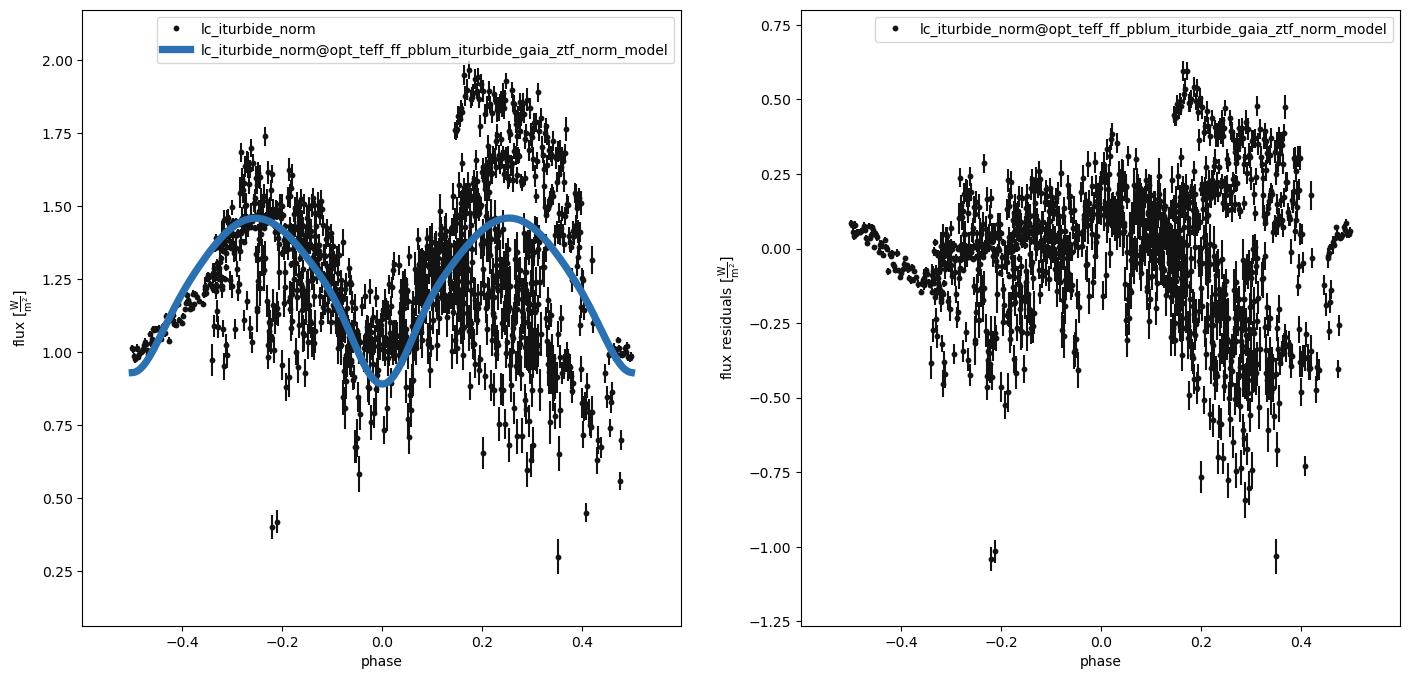

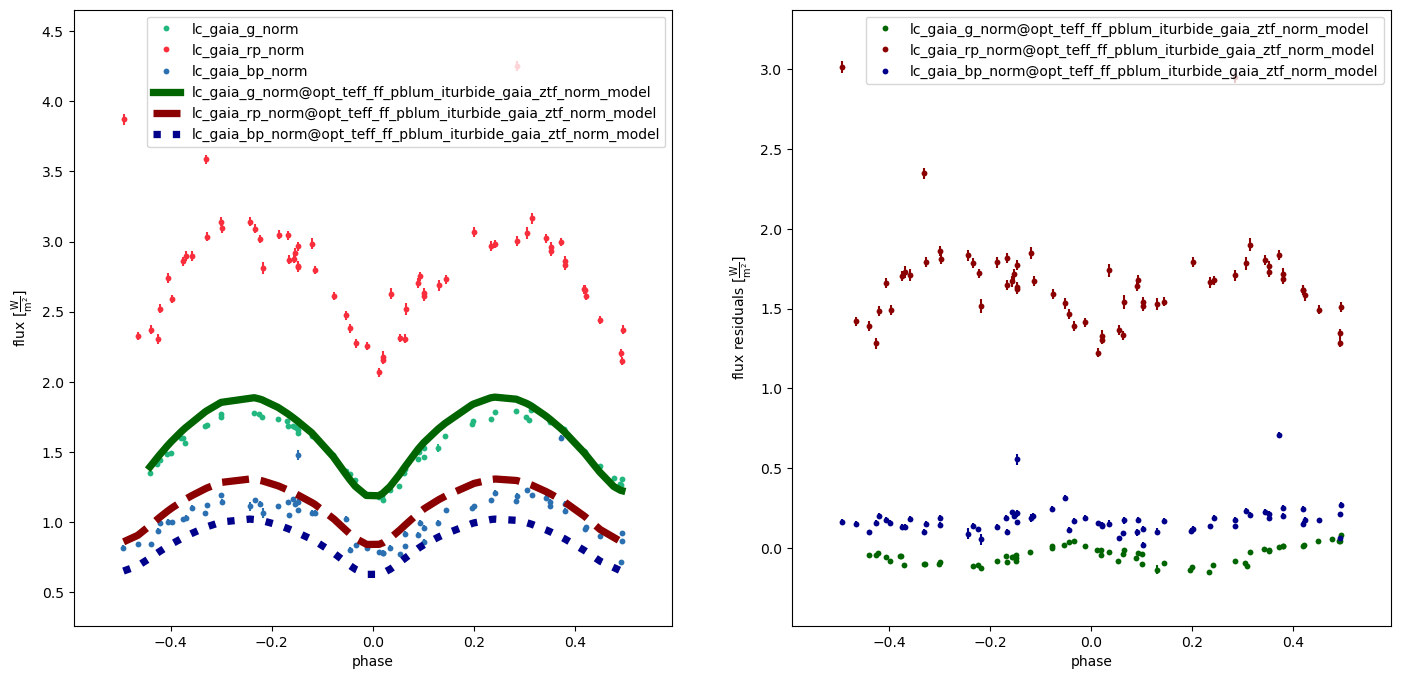

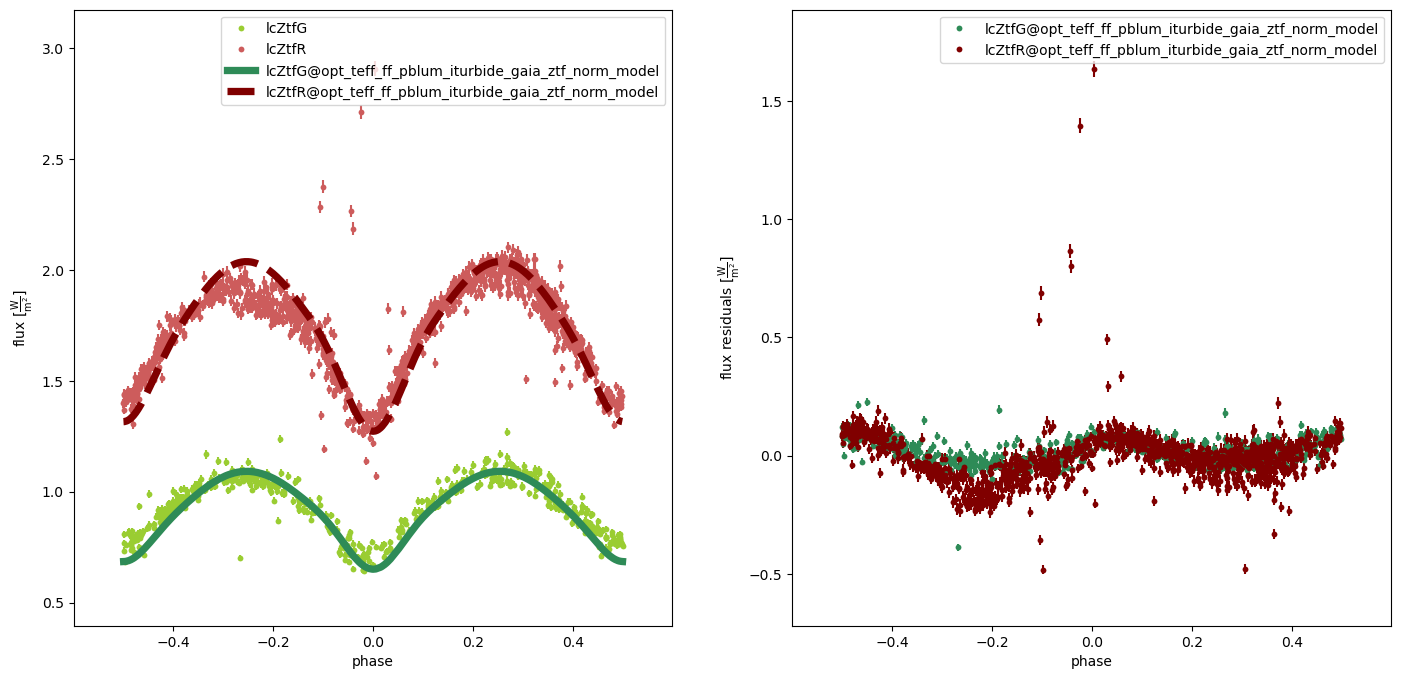

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [19]:
solutionName, computeModelName = opt_utils.adopt_solution(b, 
													solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_teff_ff_pblum_iturbide_gaia_ztf_norm_solution", 
													reset_params=True, dataset=['mesh01', 'lc_iturbide_norm'] + normGaiaDatasets + ztfDatasets)
gen_utils.plotModelResidualsFigsize(b, figsize=(17, 8), datasetGroups=[['lc_iturbide_norm'], normGaiaDatasets, ztfDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)

In [41]:
# raw datasets only
opt_utils.optimize_params(b, label="teff_ff_pblum_iturbide_gaia_raw", export=True, subfolder="iturbide-gaia-ztf-ltt", 
						  fit_twigs=['teffratio', 'fillout_factor', 'teff@primary', 'pblum@primary@lc_gaia_g_raw', 'pblum@primary@lc_iturbide_raw'],
						  datasets=rawGaiaDatasets + ['lc_iturbide_raw'], maxiter=500)

External Solver: ./external-jobs/iturbide-gaia-ztf-ltt/optimizer.nelder_mead_opt_teff_ff_pblum_iturbide_gaia_raw.py ./results/opt_teff_ff_pblum_iturbide_gaia_raw_solution


('opt_teff_ff_pblum_iturbide_gaia_raw',
 'opt_teff_ff_pblum_iturbide_gaia_raw_solution')

In [44]:
# raw + ZTF
opt_utils.optimize_params(b, label="teff_ff_pblum_iturbide_gaia_ztf_raw", export=True, subfolder="iturbide-gaia-ztf-ltt", 
						  fit_twigs=['teffratio', 'fillout_factor', 'teff@primary', 'pblum@primary@lc_gaia_g_raw', 'pblum@primary@lc_iturbide_raw', 'pblum@primary@lcZtfG'],
						  datasets=rawGaiaDatasets + ztfDatasets + ['lc_iturbide_raw'], maxiter=500)

External Solver: ./external-jobs/iturbide-gaia-ztf-ltt/optimizer.nelder_mead_opt_teff_ff_pblum_iturbide_gaia_ztf_raw.py ./results/opt_teff_ff_pblum_iturbide_gaia_ztf_raw_solution


('opt_teff_ff_pblum_iturbide_gaia_ztf_raw',
 'opt_teff_ff_pblum_iturbide_gaia_ztf_raw_solution')

### Adjusting Sets of Colors

3 different optimizers to determine component $T_{eff}$: using only Gaia color ($BP - RP$), using only ZTF color ($G - R$), and one using both sets of light curves.

Only adjusting `teffratio`, `teff@primary`, and `pblum`; adjusting radii using `fillout_factor` should probably be done before changing passband scaling.

In [24]:
# gaia only
opt_utils.optimize_params(b, fit_twigs=['teffratio', 'teff@primary', 'pblum@primary@lc_gaia_rp_norm'], label='gaia_br_teff', export=True,
						  datasets=['lc_gaia_rp_norm', 'lc_gaia_bp_norm'], subfolder='iturbide-gaia-ztf-relative_norm', maxiter=500)

# ztf only
opt_utils.optimize_params(b, fit_twigs=['teffratio', 'teff@primary', 'pblum@primary@lcZtfG'], label='ztf_teff', export=True,
						  datasets=ztfDatasets, subfolder='iturbide-gaia-ztf-relative_norm', maxiter=250)

# gaia + ztf
opt_utils.optimize_params(b, fit_twigs=['teffratio', 'teff@primary', 'pblum@primary@lcZtfG', 'pblum@primary@lc_gaia_rp_norm'], label='gaia_br_ztf_teff', export=True,
						  datasets=['lc_gaia_rp_norm', 'lc_gaia_bp_norm'] + ztfDatasets, subfolder='iturbide-gaia-ztf-relative_norm', maxiter=500)

External Solver: ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_gaia_br_teff.py ./results/opt_gaia_br_teff_solution
External Solver: ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_ztf_teff.py ./results/opt_ztf_teff_solution
External Solver: ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_gaia_br_ztf_teff.py ./results/opt_gaia_br_ztf_teff_solution


('opt_gaia_br_ztf_teff', 'opt_gaia_br_ztf_teff_solution')

Adopted:
teffratio@binary@orbit@component = 1.00425 
teff@primary@star@component = 3908.94423 K
pblum@primary@lc_gaia_rp_norm@lc@dataset = 10.53618 W

Original values:
  teffratio@binary@orbit@component 0.9857284692267768
  teff@primary@star@component 6000.0 K
  pblum@primary@lc_gaia_rp_norm@lc@dataset 12.566370614359172 W


100%|██████████| 1864/1864 [05:23<00:00,  5.75it/s]


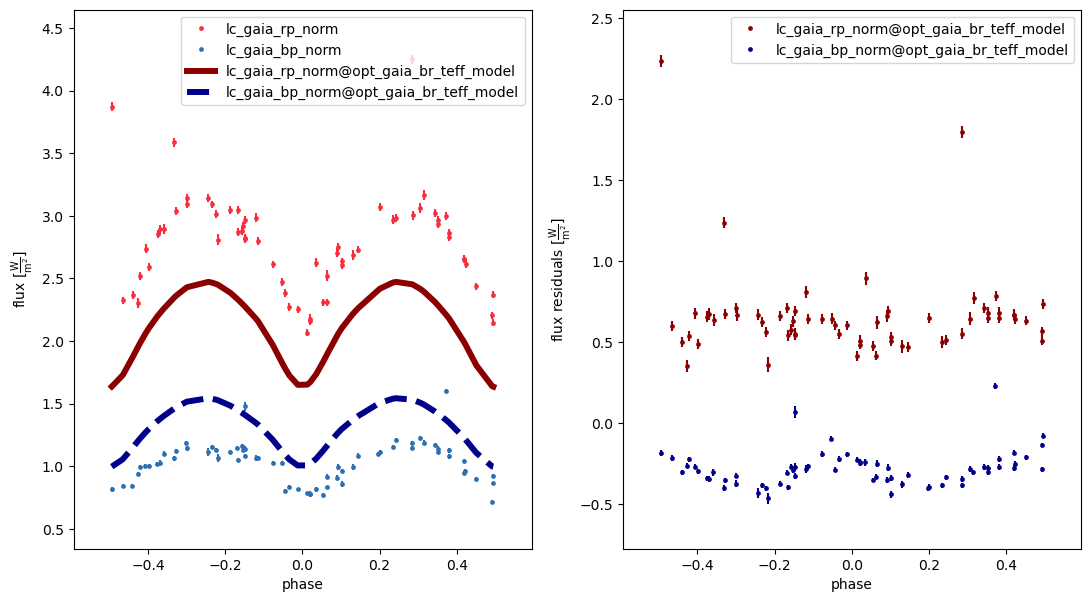

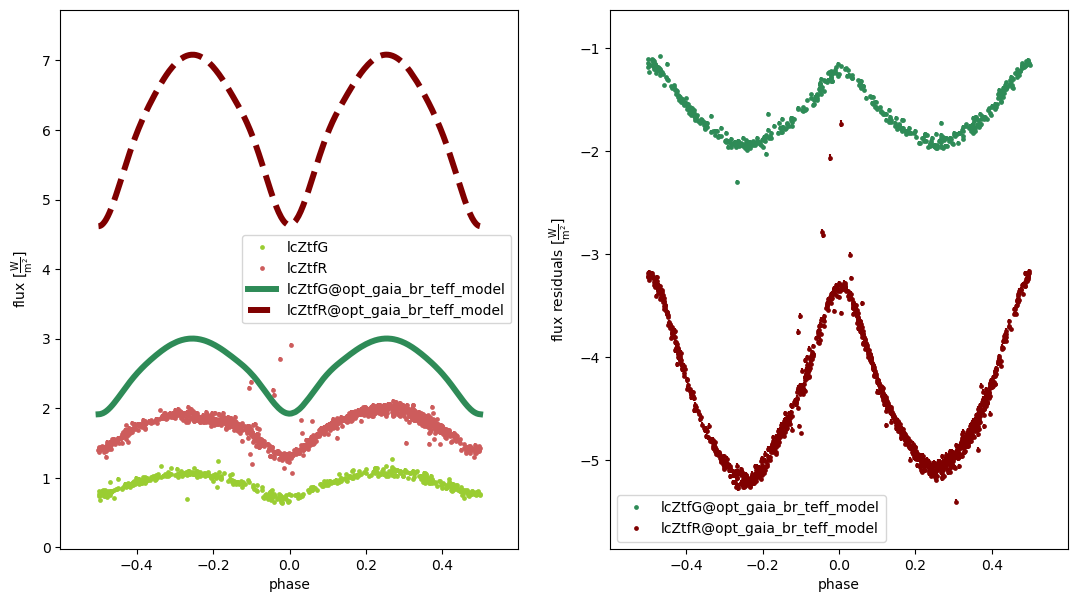

{'lc_gaia_rp_norm-lc_gaia_bp_norm': <Figure size 1300x700 with 2 Axes>,
 'lcZtfG-lcZtfR': <Figure size 1300x700 with 2 Axes>}

In [25]:
# gaia only
gen_utils.abilitateDatasets(b, ['lc_gaia_rp_norm', 'lc_gaia_bp_norm'] + ztfDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_gaia_br_teff_solution", reset_params=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[['lc_gaia_rp_norm', 'lc_gaia_bp_norm'], ztfDatasets], model=computeModelName)